In [1]:
pip install pyro-ppl torch arviz numpy pandas matplotlib statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
from statsmodels.datasets import get_rdataset

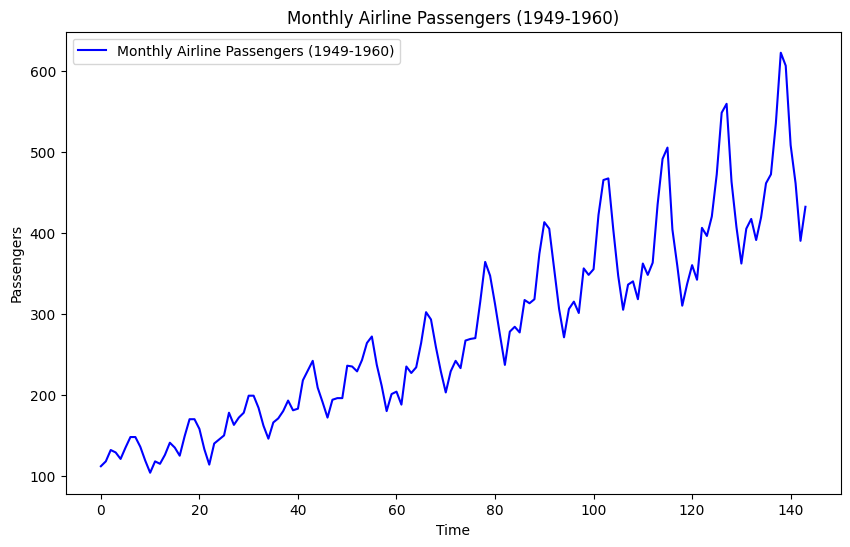

In [3]:
# Load the AirPassengers dataset
data = get_rdataset("AirPassengers").data
AP = data["value"].values

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(AP, color="blue", label="Monthly Airline Passengers (1949-1960)")
plt.title("Monthly Airline Passengers (1949-1960)")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [4]:
# Prepare the data for autoregressive modeling
p = 2  # Number of lags (autoregressive order)
X = np.array([AP[i:i + p] for i in range(len(AP) - p)])
y = np.array([AP[i + p] for i in range(len(AP) - p)])

# Convert data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [5]:
# Define the Bayesian Autoregressive (BAR) model using Pyro
def bar_model(X, y):
    # Priors for autoregressive coefficients
    a0 = pyro.sample("a0", dist.Normal(0, 1))
    a1 = pyro.sample("a1", dist.Normal(0, 1))
    a2 = pyro.sample("a2", dist.Normal(0, 1))

    # Prior for model variance
    sigma = pyro.sample("sigma", dist.Exponential(1))

    # Expected value of the AR(2) process
    mu = a0 + a1 * X[:, 0] + a2 * X[:, 1]

    # Likelihood
    with pyro.plate("data", len(y)):
        pyro.sample("y_obs", dist.Normal(mu, sigma), obs=y)

In [7]:
# Run MCMC with NUTS (No-U-Turn Sampler)
nuts_kernel = NUTS(bar_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=200, num_chains=2)

# Run the MCMC sampler
mcmc.run(X, y)

# Summary of the model
mcmc.summary()

/usr/local/lib/python3.11/dist-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Sample [1]: 100%|██████████| 700/700 [01:42,  6.86it/s, step size=9.35e-02, acc. prob=0.939]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0      0.39      0.95      0.37     -1.33      1.78    553.13      1.00
        a1     -0.30      0.07     -0.30     -0.40     -0.18    372.91      1.00
        a2      1.30      0.07      1.30      1.17      1.40    370.70      1.00
     sigma     29.57      1.49     29.50     27.18     31.94    638.71      1.00

Number of divergences: 0


array([[<Axes: title={'center': 'a0'}>, <Axes: title={'center': 'a0'}>],
       [<Axes: title={'center': 'a1'}>, <Axes: title={'center': 'a1'}>],
       [<Axes: title={'center': 'a2'}>, <Axes: title={'center': 'a2'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

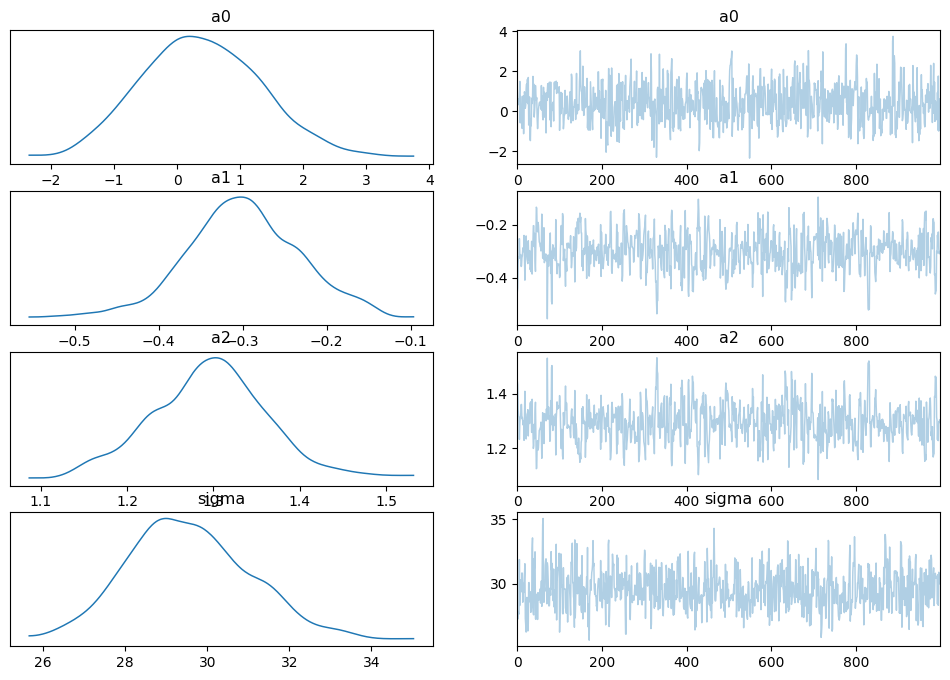

In [8]:
# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Plot the posterior distributions using ArviZ
az.plot_trace(posterior_samples, var_names=["a0", "a1", "a2", "sigma"])

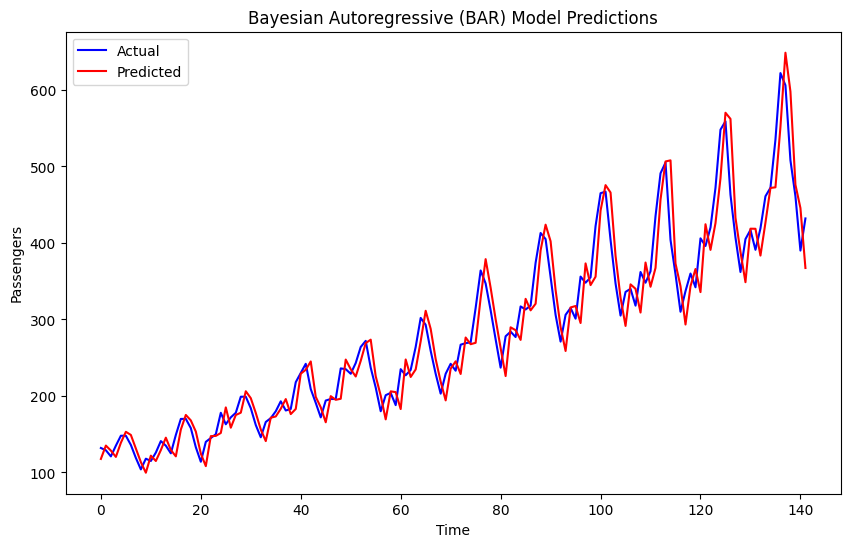

In [10]:
# Posterior predictive checks
def posterior_predictive(X, posterior_samples):
    a0 = posterior_samples["a0"]  # Shape: (num_samples,)
    a1 = posterior_samples["a1"]  # Shape: (num_samples,)
    a2 = posterior_samples["a2"]  # Shape: (num_samples,)
    sigma = posterior_samples["sigma"]  # Shape: (num_samples,)

    # Compute mu for each sample
    mu = a0[:, None] + a1[:, None] * X[:, 0] + a2[:, None] * X[:, 1]  # Shape: (num_samples, num_observations)

    # Generate posterior predictive samples
    y_pred = np.random.normal(mu, sigma[:, None])  # Shape: (num_samples, num_observations)
    return y_pred

# Generate posterior predictive samples
y_pred = posterior_predictive(X, posterior_samples)  # Shape: (num_samples, num_observations)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y.numpy(), color="blue", label="Actual")
plt.plot(y_pred.mean(axis=0), color="red", label="Predicted")  # Mean over samples
plt.title("Bayesian Autoregressive (BAR) Model Predictions")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.show()